In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
from APT_coherence_T_utils import *

In [4]:
import os
import sys
import importlib
import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt

# Prefer the installed rqc package, not the local repo copy in control_transition
SITE_PACKAGES = '/p/home/hpan/.pyenv/versions/miniforge3-25.1.1-2/lib/python3.12/site-packages'
PROJECT_ROOT = os.path.expandvars('$WORKDIR/control_transition')
LOCAL_RQC = str(Path(PROJECT_ROOT) / 'rqc')

clean_sys_path = []
for p in sys.path:
    if p in ('', os.getcwd(), PROJECT_ROOT, LOCAL_RQC):
        continue
    if 'control_transition' in p and 'site-packages' not in p:
        continue
    clean_sys_path.append(p)
if SITE_PACKAGES not in clean_sys_path:
    clean_sys_path.insert(0, SITE_PACKAGES)
sys.path = clean_sys_path

if 'rqc' in sys.modules:
    del sys.modules['rqc']
importlib.invalidate_caches()
import rqc




In [24]:
def _load_pickle_with_swap(fn):
    data = rqc.load_pickle(fn)
    coherence = data.get('coherence')
    if coherence is not None and getattr(coherence, 'ndim', 0) == 5:
        # stored as (p_m, p_f, es_m, es_C, T); swap axes to match parse_APT_T expectation
        data['coherence'] = np.swapaxes(coherence, 2, 3)
    return data


def _load_zip_pickle_with_swap(fn, z):
    data = rqc.load_zip_pickle(fn, z)
    coherence = data.get('coherence')
    if coherence is not None and getattr(coherence, 'ndim', 0) == 5:
        data['coherence'] = np.swapaxes(coherence, 2, 3)
    return data


def load_apt_coherence(use_zip=True, L_list=(12, 14, 16, 18, 20, 22, 24), p_f=1, p_f_int=1,zipfilename='APT_coherence_T_pf1.zip', 
                       p_m_list = np.hstack([np.arange(0, 0.08, 0.01), np.arange(0.08, 0.101, 0.005),np.arange(0.11, 0.2, 0.01)]),
BATCH_CONFIG = {
    12: {'es_C_batch': 2000, 'num_batches': 2},
    14: {'es_C_batch': 2000, 'num_batches': 2},
    16: {'es_C_batch': 2000, 'num_batches': 2},
    18: {'es_C_batch': 2000, 'num_batches': 2},
    20: {'es_C_batch': 1000, 'num_batches': 4},
    22: {'es_C_batch': 24*10, 'num_batches': 4000//(24*10)+1},
    24: {'es_C_batch': 24*2, 'num_batches': 4000//(24*2)+1}
}):
    """Load APT coherence pickles into a parsed dictionary using rqc.generate_params."""
    load_data = _load_zip_pickle_with_swap if use_zip else _load_pickle_with_swap
    data_dict = {'fn': set()}
    FN_TEMPLATE = (
    'APT_En(1,2)_EnC({es_C_range[0]},{es_C_range[1]})_pm({p_m:.3f},{p_m:.3f},1)_pf({p_f:.3f},{p_f:.3f},{p_f_int:d})_L{L}_coherence_T.pickle'
)   
    ZIP_PATH = os.path.expandvars(f'$WORKDIR/control_transition/{zipfilename}')



    for L in L_list:
        cfg = BATCH_CONFIG[L]
        es_ranges = []
        for batch_idx in range(cfg['num_batches']):
            es_start = 1 + batch_idx * cfg['es_C_batch']
            # es_end = min(1 + (batch_idx + 1) * cfg['es_C_batch'], 2001)
            es_end = 1 + (batch_idx + 1) * cfg['es_C_batch']
            es_ranges.append((es_start, es_end))

        data_dict = rqc.generate_params(
            # fixed_params={'es_start': 1, 'es_end': 2, 'p_f': -1, 'L': L},
            fixed_params={'es_start': 1, 'es_end': 2, 'p_f': p_f, 'L': L, 'p_f_int': p_f_int},
            vary_params={'p_m': p_m_list, 'es_C_range': es_ranges},
            fn_template=FN_TEMPLATE,
            fn_dir_template='.',
            input_params_template='',
            load_data=load_data,
            filename=None,
            filelist=None,
            load=True,
            data_dict=data_dict,
            zip_fn=ZIP_PATH if use_zip else None,
        )

    return data_dict


def apt_coherence_to_df(data_dict):
    """Convert the loaded coherence dictionary to a pandas DataFrame."""
    return rqc.convert_pd(data_dict, names=['Metrics', 'L', 'p_m', 'p_f', 'es_C', 'es_m'])

# Example:
# data_dict = load_apt_coherence()
# df = apt_coherence_to_df(data_dict)

In [131]:
os.environ['WORKDIR']="/scratch/hp636/"

In [132]:
data_dict_pf1 = load_apt_coherence(p_f=1, p_f_int=1, zipfilename='APT_coherence_T_pf1_6L.zip',
BATCH_CONFIG = {
    12: {'es_C_batch': 2000, 'num_batches': 2},
    14: {'es_C_batch': 2000, 'num_batches': 2},
    16: {'es_C_batch': 2000, 'num_batches': 2},
    18: {'es_C_batch': 2000, 'num_batches': 2},
    20: {'es_C_batch': 1000, 'num_batches': 4},
    22: {'es_C_batch': 24*10, 'num_batches': 4000//(24*10)+1},
    24: {'es_C_batch': 24*2, 'num_batches': 4000//(24*2)+1}
},
p_m_list =  np.hstack([np.arange(0, 0.06, 0.02), np.arange(0.06, 0.08, 0.01), np.arange(0.085, 0.101, 0.005),np.arange(0.11, 0.13, 0.01), ])
)

generate_params: 100%|██████████| 1092/1092 [00:01<00:00, 637.36it/s]


In [133]:
list(data_dict_pf1.keys())[-1]

('coherence',
 24,
 np.float64(0.13),
 np.float64(1.0),
 np.int64(4032),
 np.int64(1))

In [134]:
data_pf1_df = apt_coherence_to_df(data_dict_pf1)

In [135]:
data_pf1_df

observations
Metrics   L  p_m  p_f es_C es_m                                                   
coherence 12 0.00 1.0 1    1     [906.8074456317973, 2157.45638227963, 2711.435...
                      2    1     [825.004505791548, 2289.8086414157174, 2909.32...
                      3    1     [916.1432764541147, 2398.8460723393423, 2780.8...
                      4    1     [1126.0416346148793, 2177.636681437101, 2793.8...
                      5    1     [1392.2096317665423, 2376.3273486885937, 3000....
...                                                                            ...
          24 0.13 1.0 4028 1     [89089.90458969011, 99884.32965115269, 173253....
                      4029 1     [25170.441625579693, 447760.9092436906, 125207...
                      4030 1     [838888.1049091604, 1307064.238625066, 503386....
                      4031 1     [63647.456813272656, 44203.20480300806, 70836....
                      4032 1     [22134.73989714921, 205366.88739861807, 125135...

[281840 rows x 1 columns]

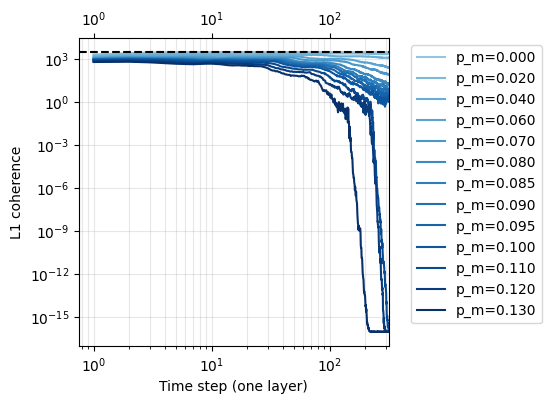

In [12]:
plot_apt_coherence_T_vs_steps_fixedL(data_pf1_df, L=12)


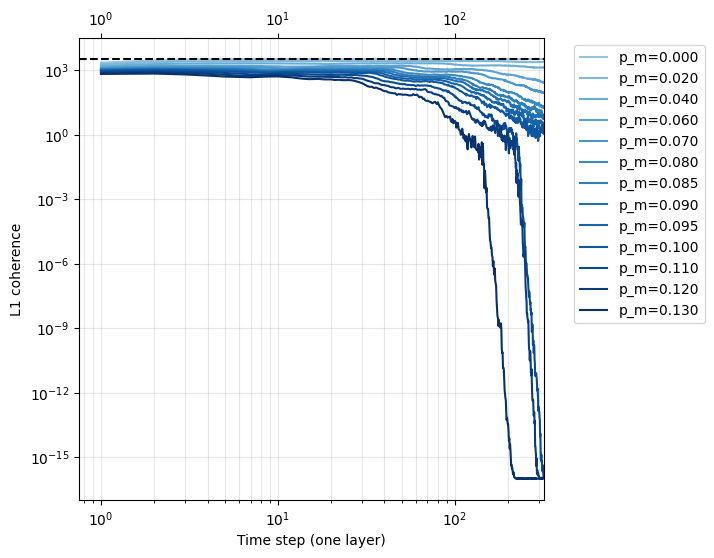

In [35]:
plot_apt_coherence_T_vs_steps_fixedL(data_pf1_df, L=12)


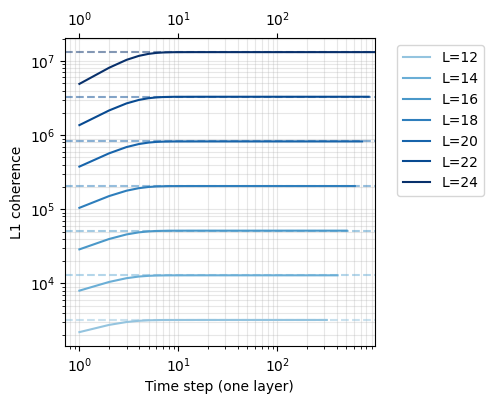

In [39]:
plot_apt_coherence_T_vs_steps_fixedp_m(data_pf1_df, p_m=0.00)

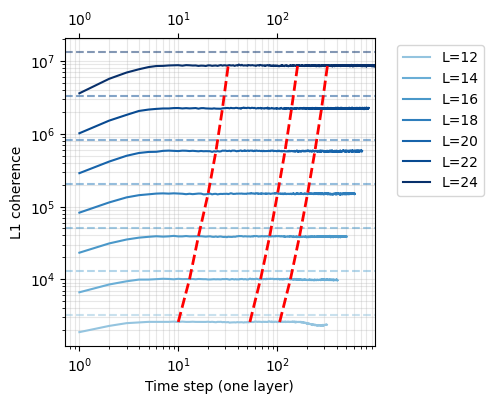

In [43]:
plot_apt_coherence_T_vs_steps_fixedp_m(data_pf1_df, p_m=0.02, prefactor=[.2,1,2])

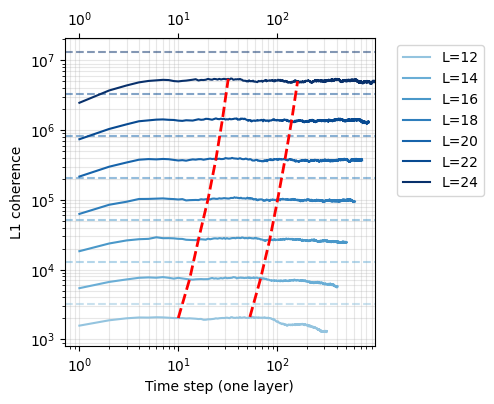

In [44]:
plot_apt_coherence_T_vs_steps_fixedp_m(data_pf1_df, p_m=0.04, prefactor=[.2,1])

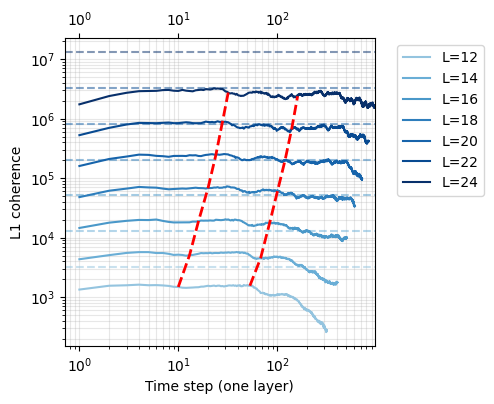

In [45]:
plot_apt_coherence_T_vs_steps_fixedp_m(data_pf1_df, p_m=0.06, prefactor=[.2,1])

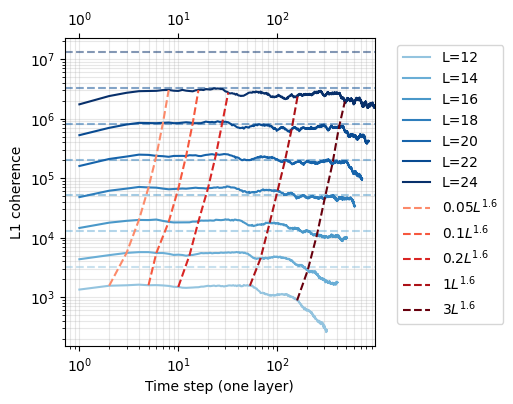

In [59]:
plot_apt_coherence_T_vs_steps_fixedp_m(data_pf1_df, p_m=0.06, prefactor=[.05,.1,.2,1,3])

4000
4000
4000
4000
4000
4080
3744


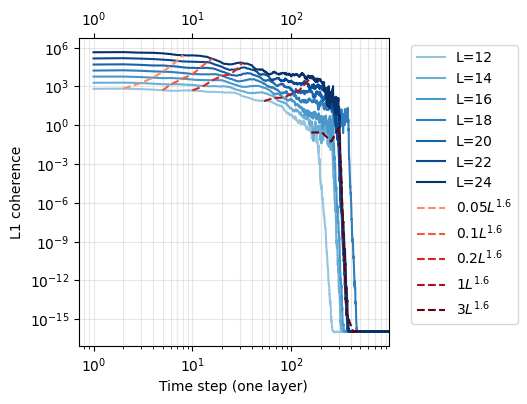

In [61]:
plot_apt_coherence_T_vs_steps_fixedp_m(data_pf1_df, p_m=0.13, prefactor=[.05,.1,.2,1,3], theory_line=False)


4000
4000
4000
4000
4000
4080
3744


(1.0, 1000000.0)

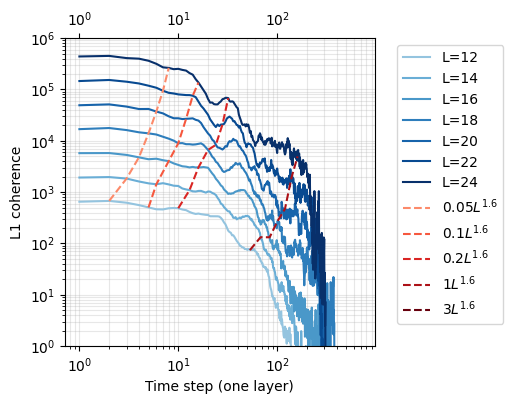

In [62]:
plot_apt_coherence_T_vs_steps_fixedp_m(data_pf1_df, p_m=0.13, prefactor=[.05,.1,.2,1,3], theory_line=False)
plt.ylim(1e0,1e6)

4000
4000
4000
4000
4000
4080
3744


(1.0, 1000000.0)

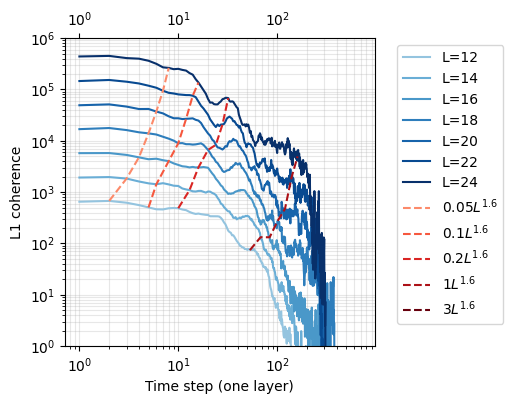

In [38]:
plot_apt_coherence_T_vs_steps_fixedp_m(data_pf1_df, p_m=0.13, prefactor=[.05,.1,.2,1,3], theory_line=False)
plt.ylim(1e0,1e6)

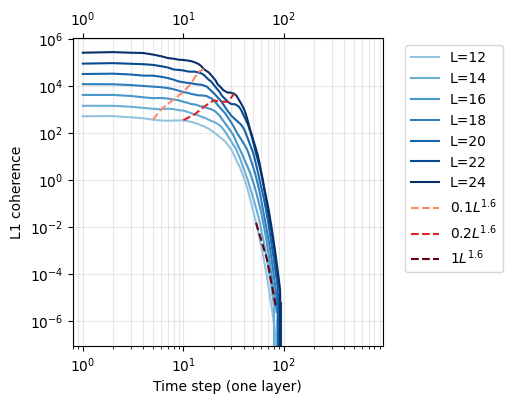

In [82]:
plot_apt_coherence_T_vs_steps_fixedp_m(data_pf1_df, p_m=0.12, prefactor=[.1,.2,1,], average_log=True)

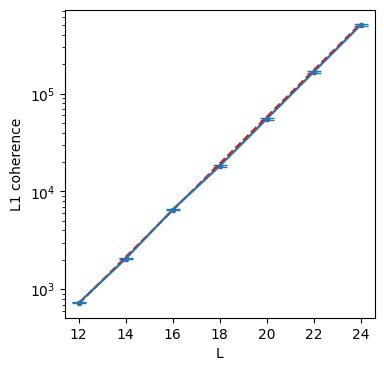

In [78]:
plot_apt_coherence_T_vs_L(data_pf1_df, p_m=0.11, min_func=lambda L: int(0.1*L**1.6), max_func=lambda L: int(0.1*L**1.6)+1, idx_max=3)

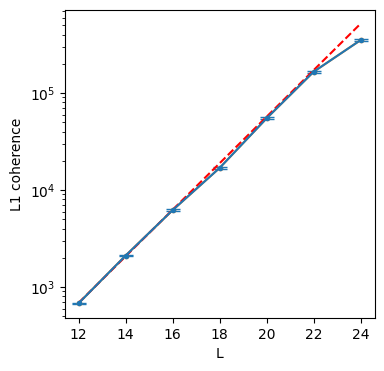

In [77]:
plot_apt_coherence_T_vs_L(data_pf1_df, p_m=0.11, min_func=lambda L: int(0.12*L**1.6), max_func=lambda L: int(0.12*L**1.6)+1, idx_max=3)

Text(0.5, 1.0, '$p_{m}=0.0$')

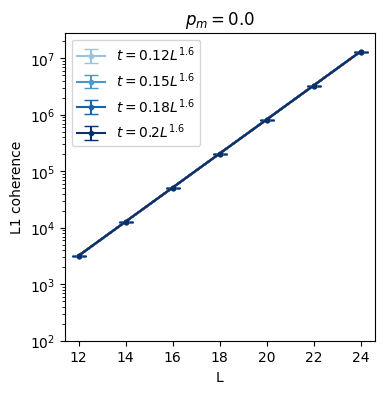

In [118]:
fig, ax =plt.subplots(figsize=(4, 4))
t_list = [0.12,0.15, 0.18, 0.2,]
color_list = plt.cm.Blues(np.linspace(0.4, 1, len(t_list)))
p_m  = 0.0
for idx,t in enumerate(t_list):
    plot_apt_coherence_T_vs_L(data_pf1_df, p_m=p_m, min_func=lambda L: int(t*L**1.6), max_func=lambda L: int(t*L**1.6)+1, idx_max=3, ax=ax, color = color_list[idx], label=f'$t={t}L^{{1.6}}$')
ax.legend()
ax.set_ylim(1e2,None)
ax.set_title(f'$p_{{m}}={p_m}$')    

Text(0.5, 1.0, '$t=0.2L^{1.6}$')

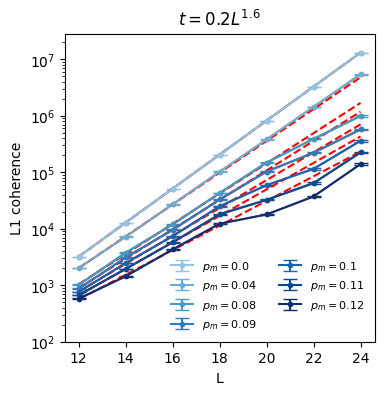

In [137]:
fig, ax =plt.subplots(figsize=(4, 4))
t=0.2
p_m_list  = [0.0, 0.04, 0.08, 0.09, 0.10,0.11,0.12]
color_list = plt.cm.Blues(np.linspace(0.4, 1, len(p_m_list)))
for idx,p_m in enumerate(p_m_list):
    plot_apt_coherence_T_vs_L(data_pf1_df, p_m=p_m, min_func=lambda L: int(t*L**1.6), max_func=lambda L: int(t*L**1.6)+1, idx_max=3, ax=ax, color = color_list[idx], label=f'$p_{{m}}={p_m}$')
ax.legend(ncols=2, fontsize=8,frameon=False)
ax.set_ylim(1e2,None)
ax.set_title(f'$t={t}L^{{1.6}}$')    

<>:9: SyntaxWarning: invalid escape sequence '\i'
<>:9: SyntaxWarning: invalid escape sequence '\i'
/tmp/ipykernel_12483/2074251437.py:9: SyntaxWarning: invalid escape sequence '\i'
  ax.set_title(f'$t\in{t}L^{{1.6}}$')


Text(0.5, 1.0, '$t\\in[0.12, 0.2]L^{1.6}$')

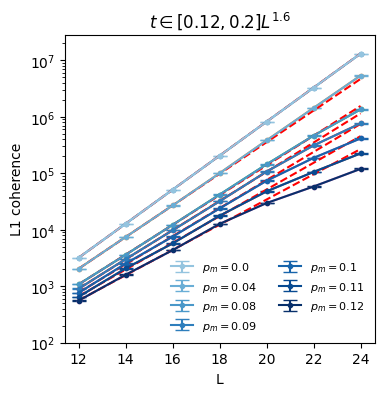

In [136]:
fig, ax =plt.subplots(figsize=(4, 4))
t=[0.12, 0.2]
p_m_list  = [0.0, 0.04, 0.08, 0.09, 0.10,0.11,0.12]
color_list = plt.cm.Blues(np.linspace(0.4, 1, len(p_m_list)))
for idx,p_m in enumerate(p_m_list):
    plot_apt_coherence_T_vs_L(data_pf1_df, p_m=p_m, min_func=lambda L: int(t[0]*L**1.6), max_func=lambda L: int(t[1]*L**1.6)+1, idx_max=3, ax=ax, color = color_list[idx], label=f'$p_{{m}}={p_m}$')
ax.legend(ncols=2, fontsize=8,frameon=False)
ax.set_ylim(1e2,None)
ax.set_title(f'$t\in{t}L^{{1.6}}$')    

<>:9: SyntaxWarning: invalid escape sequence '\i'
<>:9: SyntaxWarning: invalid escape sequence '\i'
/tmp/ipykernel_12483/3299609506.py:9: SyntaxWarning: invalid escape sequence '\i'
  ax.set_title(f'$t\in{t}L^{{1.6}}$')


Text(0.5, 1.0, '$t\\in[0.12, 0.18]L^{1.6}$')

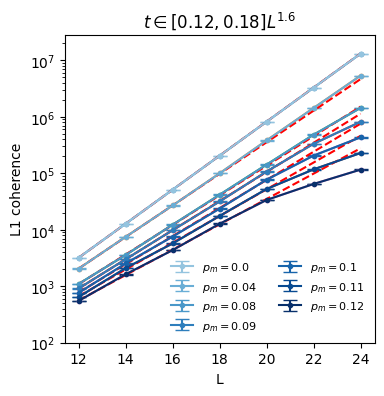

In [138]:
fig, ax =plt.subplots(figsize=(4, 4))
t=[0.12, 0.18]
p_m_list  = [0.0, 0.04, 0.08, 0.09, 0.10,0.11,0.12]
color_list = plt.cm.Blues(np.linspace(0.4, 1, len(p_m_list)))
for idx,p_m in enumerate(p_m_list):
    plot_apt_coherence_T_vs_L(data_pf1_df, p_m=p_m, min_func=lambda L: int(t[0]*L**1.6), max_func=lambda L: int(t[1]*L**1.6)+1, idx_max=3, ax=ax, color = color_list[idx], label=f'$p_{{m}}={p_m}$')
ax.legend(ncols=2, fontsize=8,frameon=False)
ax.set_ylim(1e2,None)
ax.set_title(f'$t\in{t}L^{{1.6}}$')    

In [ ]:
in slurm_out, i wnat to find a file which both contain `L 22` and `DUE TO TIME LIMIT`

In [1]:
384/24

16.0

In [2]:
10*60/16

37.5

In [ ]:
L=22

In [16]:
24*10, 2000//(24*10)+1

(240, 9)

In [ ]:
L=24

In [20]:
24*2, 2000//(24*2)+1

(48, 42)

In [ ]:
L=22 : 9:46:51/(384/24) = 

In [ ]:
L = 24 : 9:52:55/3 = 3h20

In [21]:
import numpy as np

In [23]:
len(np.hstack([np.arange(0, 0.06, 0.02), np.arange(0.06, 0.08, 0.01), np.arange(0.085, 0.101, 0.005),np.arange(0.11, 0.13, 0.01), ]))

13